In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from typing import Any
# from INRF import INRF
# from INRF_Conv import INRF
# from INRF_Conv_Gauss import INRF
# from INRF_Conv_Gauss_Delta import INRF as INRF_DC
from INRF_Conv_Gauss_Map import INRF
import numpy as np
from einops import rearrange
import jax
from jax import random, numpy as jnp
import flax
from flax import struct
from flax.core import freeze, unfreeze, FrozenDict, pop
import flax.linen as nn
from flax.training import train_state
from clu import metrics
import dm_pix as pix
import optax
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], device_type="GPU")

from iqadatasets.datasets import *
from paramperceptnet.layers import *
from paramperceptnet.training import train_step, compute_metrics, pearson_correlation
from paramperceptnet.configs import param_config
from layers import *
from fxlayers.layers import pad_same_from_kernel_size

In [6]:
## Load data
dst_train = TID2008("/media/disk/vista/BBDD_video_image/Image_Quality/TID/TID2008/", exclude_imgs=[25]).dataset
dst_test = TID2013("/media/disk/vista/BBDD_video_image/Image_Quality/TID/TID2013/", exclude_imgs=[25]).dataset

In [7]:
def preprocess(img, dist, mos):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size=(384//1, 512//1))
    dist = tf.image.rgb_to_grayscale(dist)
    dist = tf.image.resize(dist, size=(384//1, 512//1))
    return img, dist, mos

In [8]:
dst_train_rdy = dst_train.shuffle(buffer_size=50, seed=42, reshuffle_each_iteration=True)\
                         .batch(8, num_parallel_calls=tf.data.AUTOTUNE)\
                         .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                         .prefetch(1)
dst_test_rdy = dst_test.batch(8, num_parallel_calls=tf.data.AUTOTUNE)\
                        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                        .prefetch(1)

In [9]:
img, dist, mos = next(iter(dst_train_rdy))
img.shape, dist.shape, mos.shape

(TensorShape([8, 384, 512, 1]),
 TensorShape([8, 384, 512, 1]),
 TensorShape([8]))

In [10]:
## Boilerplate
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")


class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict


def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = pop(variables, "params")
    return TrainState.create(
        apply_fn=module.apply,
        params=freeze(params),
        state=freeze(state),
        tx=tx,
        metrics=Metrics.empty(),
    )

In [11]:
def generate_patches(img, n_patches):
    b, h, w, c = img.shape
    h_p, w_p = h//n_patches, w//n_patches
    patches = pix.extract_patches(img, [1,h_p,w_p,1], strides=[1,h_p,w_p,1], rates=[1,1,1,1])
    patches = jnp.reshape(patches, shape=(b, n_patches, n_patches, h_p, w_p, c))
    return patches
# patches = generate_patches(img.numpy(), n_patches=2)
# patches.shape

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    config: Any

    @nn.compact
    def __call__(
        self,
        inputs,  # Assuming fs = 128 (cpd)
        **kwargs,
    ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if self.config.USE_GAMMA:
            outputs = GDNGamma()(inputs)
        else:
            outputs = GDN(kernel_size=(1, 1), apply_independently=True)(inputs)

        ## Color (ATD) Transformation
        # outputs = nn.Conv(features=3, kernel_size=(1, 1), use_bias=False, name="Color")(
        #     outputs
        # )
        outputs = nn.max_pool(outputs, window_shape=(2, 2), strides=(2, 2))

        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1, 1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        l = INRF(features=1, kernel_size=21, fs=21, padding="VALID", batch_size=10)
        patches = generate_patches(outputs, n_patches=self.config.n_patches) # [B, Np, Np, Hp, Wp, C]
        b, np1, np2, hp, wp, c = patches.shape
        patches = rearrange(patches, "b np1 np2 hp wp c -> (np1 np2) b hp wp c")
        preds_patches = []
        for patch in patches:
            patch = pad_same_from_kernel_size(patch, kernel_size=55, mode="symmetric")
            pred_patch = l(patch, **kwargs)
            preds_patches.append(pred_patch)
        preds_patches = rearrange(jnp.array(preds_patches), "(np1 np2) b hp wp c -> b (np1 hp) (np2 wp) c", np1=np1, np2=np2)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(
            outputs, kernel_size=self.config.GABOR_KERNEL_SIZE, mode="symmetric"
        )
        # outputs, fmean, theta_mean = GaborLayerGamma_(n_scales=4+2+2, n_orientations=8*3, kernel_size=self.config.GABOR_KERNEL_SIZE, fs=32, xmean=self.config.GABOR_KERNEL_SIZE/32/2, ymean=self.config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=self.config.NORMALIZE_PROB, normalize_energy=self.config.NORMALIZE_ENERGY, zero_mean=self.config.ZERO_MEAN, use_bias=self.config.USE_BIAS, train_A=self.config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(
            n_scales=[4],
            n_orientations=[8],
            kernel_size=self.config.GABOR_KERNEL_SIZE,
            fs=32,
            xmean=self.config.GABOR_KERNEL_SIZE / 32 / 2,
            ymean=self.config.GABOR_KERNEL_SIZE / 32 / 2,
            strides=1,
            padding="VALID",
            normalize_prob=self.config.NORMALIZE_PROB,
            normalize_energy=self.config.NORMALIZE_ENERGY,
            zero_mean=self.config.ZERO_MEAN,
            use_bias=self.config.USE_BIAS,
            train_A=self.config.A_GABOR,
        )(outputs, return_freq=True, return_theta=True, **kwargs)

        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioChromaFreqOrient(
            # kernel_size=self.config.GDNFINAL_KERNEL_SIZE,
            kernel_size=21,
            strides=1,
            padding="symmetric",
            fs=32,
            apply_independently=False,
            normalize_prob=self.config.NORMALIZE_PROB,
            normalize_energy=self.config.NORMALIZE_ENERGY,
        )(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

In [13]:
# ## Model
# class Model(nn.Module):
#     n_patches: int

#     @nn.compact
#     def __call__(self, inputs, **kwargs):
#         # inputs = pad_same_from_kernel_size(inputs, 127, mode="symmetric")
#         # outputs = INRF(features=1, kernel_size=127, fs=128, l=0, padding="VALID", train_l=True)(inputs, **kwargs)
#         # outputs = INRF_DC(kernel_size=127, fs=128, l=1, padding="SAME")(inputs, **kwargs)
#         l = INRF(features=1, kernel_size=55, fs=56, l=1, padding="VALID", batch_size=10)
#         patches = generate_patches(inputs, n_patches=self.n_patches) # [B, Np, Np, Hp, Wp, C]
#         b, np1, np2, hp, wp, c = patches.shape
#         patches = rearrange(patches, "b np1 np2 hp wp c -> (np1 np2) b hp wp c")
#         preds_patches = []
#         for patch in patches:
#             patch = pad_same_from_kernel_size(patch, kernel_size=55, mode="symmetric")
#             pred_patch = l(patch, **kwargs)
#             preds_patches.append(pred_patch)
        
#         preds_patches = rearrange(jnp.array(preds_patches), "(np1 np2) b hp wp c -> b (np1 hp) (np2 wp) c", np1=np1, np2=np2)
#         return preds_patches

In [14]:
def check_trainable_fn(tree, use_bool=False):
    def check_trainable(path):
        return "trainable" if not use_bool else True
    return freeze(flax.traverse_util.path_aware_map(lambda path,v: check_trainable(path), tree))

In [15]:
param_config["n_patches"] = 4

In [16]:
state = create_train_state(PerceptNet(config=param_config), random.PRNGKey(42),
                           tx=optax.multi_transform({"trainable": optax.adam(3e-4), "non-trainable": optax.set_to_zero()}, check_trainable_fn),
                           input_shape=(1,*img.shape[1:]))
pred, s_ = state.apply_fn({"params": state.params, **state.state}, jnp.ones((1,*img.shape[1:])), train=True, mutable=list(state.state.keys()))
state = state.replace(state=s_)
total_parameters = jax.tree_util.tree_map(lambda x: x.size, state.params)
total_parameters = sum(jax.tree_util.tree_leaves(total_parameters))
trainable_parameters = jax.tree_util.tree_map(lambda x,flag: x.size if flag else 0, state.params, check_trainable_fn(state.params, use_bool=True))
trainable_parameters = sum(jax.tree_util.tree_leaves(trainable_parameters))
print(f"Trainable parameters: {trainable_parameters} | Total parameters: {total_parameters}")

2025-05-15 15:17:09.793111: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-15 15:17:10.046798: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Trainable parameters: 371 | Total parameters: 371


In [17]:
state.params

FrozenDict({
    GDNGamma_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([1.], dtype=float32),
    },
    GDNSpatioChromaFreqOrient_0: {
        B: Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
        ChromaFreqOrientGaussianGamma_0: {
            gamma_f_a: Array([1.25   , 0.625  , 0.3125 , 0.15625], dtype=float32),
            gamma_theta_a: Array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
        },
        GaussianLayerGamma_0: {
            A: Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                   1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                   1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

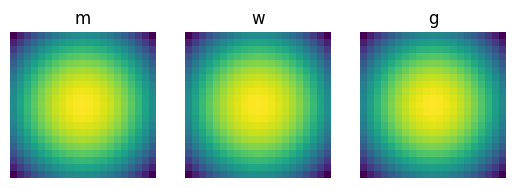

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3)
for i, k_name in enumerate(["m", "w", "g"]):
    axes[i].imshow(state.state["precalc_filter"]["INRF_0"][k_name]["kernel"][:,:,0,0])
    axes[i].set_title(k_name)
    axes[i].axis("off")
plt.show()

In [27]:
params = unfreeze(state.params)
params ["INRF_0"]["m"]["gamma"] = jnp.array([1/0.038])
params ["INRF_0"]["w"]["gamma"] = jnp.array([1/0.111])
params ["INRF_0"]["g"]["gamma"] = jnp.array([1/0.038])
params ["INRF_0"]["lambda"] = jnp.array([5.])
state = state.replace(params=freeze(params))
pred, s_ = state.apply_fn({"params": state.params, **state.state}, img.numpy()[:1], train=True, mutable=list(state.state.keys()))
state = state.replace(state=s_)

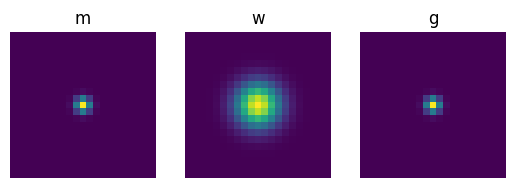

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3)
for i, k_name in enumerate(["m", "w", "g"]):
    axes[i].imshow(state.state["precalc_filter"]["INRF_0"][k_name]["kernel"][:,:,0,0])
    axes[i].set_title(k_name)
    axes[i].axis("off")
plt.show()

In [29]:
def forward(state, img):
    pred = state.apply_fn({"params": state.params, **state.state}, img)
    return pred

In [30]:
pred = forward(state, img[:1].numpy())
pred.shape

(1, 192, 256, 64)

In [31]:
# fig, axes = plt.subplots(1,2)
# m, M = min([img[:1].numpy().min(), pred.min()]), max([img[:1].numpy().max(), pred.max()])
# # axes[0].imshow(img[0], vmin=m, vmax=M)
# # axes[1].imshow(pred[0], vmin=m, vmax=M)
# axes[0].imshow(img[0])
# axes[1].imshow(pred[0])
# plt.suptitle(f"Min: {m:.3f} | Max: {M:.3f}")
# plt.show()

In [32]:
# @jax.jit
# def train_step(state, batch):
#     img, img_dist, mos = batch
#     def loss_fn(params):
#         pred, s_ = state.apply_fn({"params":params, **state.state}, img, train=True, mutable=list(state.state.keys()))
#         pred_dist, s_ = state.apply_fn({"params":params, **state.state}, img_dist, train=True, mutable=list(state.state.keys()))
#         dist = ((pred - pred_dist)**2).mean(axis=(1,2,3))**(1/2)
#         return pearson_correlation(dist, mos), s_

#     (loss, s_), grads =  jax.value_and_grad(loss_fn, has_aux=True)(state.params)
#     state = state.apply_gradients(grads=grads)
#     metrics_updates = state.metrics.single_from_model_output(loss=loss)
#     metrics = state.metrics.merge(metrics_updates)
#     state = state.replace(metrics=metrics,
#                           state=s_)
#     return loss, state

# @jax.jit
# def compute_metrics(state, batch):
#     """Obtaining the metrics for a given batch."""
#     X, Y = batch
#     def loss_fn(params):
#         pred = state.apply_fn({"params":params, **state.state}, X)
#         return optax.softmax_cross_entropy_with_integer_labels(pred, Y).mean(), pred

#     loss, pred = loss_fn(state.params)
#     metrics_updates = state.metrics.single_from_model_output(logits=pred, labels=Y, loss=loss)
#     metrics = state.metrics.merge(metrics_updates)
#     state = state.replace(metrics=metrics)
#     return state

In [33]:
## Initialize metrics
metrics_history = {'train_loss':[], 'val_loss':[]}

In [34]:
## Training Loop
epochs = 10
for epoch in range(epochs):
    ## Training ##
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)

    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Validation ##
    for batch in dst_test_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)

    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Logging ##
    print(f"Epoch {epoch} -> [Train] Loss: {metrics_history['train_loss'][-1]} | [Val] Loss: {metrics_history['val_loss'][-1]}")

2025-05-15 15:18:22.857535: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng46{k2=7,k5=2,k14=5} for conv %cudnn-conv.13 = (f32[8,64,192,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,212,276]{3,2,1,0} %bitcast.10260, f32[64,1,21,21]{3,2,1,0} %bitcast.9014), window={size=21x21}, dim_labels=bf01_oi01->bf01, feature_group_count=64, custom_call_target="__cudnn$convForward", metadata={op_name="jit(train_step)/jit(main)/jvp(PerceptNet)/GDNSpatioChromaFreqOrient_0/GaussianLayerGamma_0/conv_general_dilated" source_file="/media/disk/users/vitojor/INRFx/layers.py" source_line=157}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-15 15:18:24.014210: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.156780716s
Trying algorithm eng46{k2=7,k5=2,k1

Epoch 0 -> [Train] Loss: -0.8367381691932678 | [Val] Loss: -0.8258790969848633
Epoch 1 -> [Train] Loss: -0.8541909456253052 | [Val] Loss: -0.8271446228027344
Epoch 2 -> [Train] Loss: -0.8562228679656982 | [Val] Loss: -0.8278182148933411


In [20]:
state.params["INRF_0"]["lambda"]

Array([-0.00565255], dtype=float32)

KeyError: 'g'

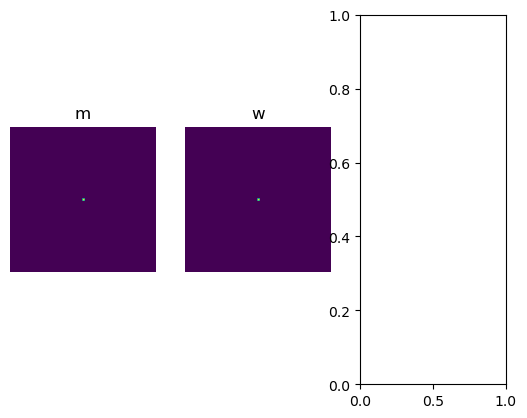

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3)
for i, k_name in enumerate(["m", "w", "g"]):
    axes[i].imshow(state.state["precalc_filter"]["INRF_0"][k_name]["kernel"][:,:,0,0])
    axes[i].set_title(k_name)
    axes[i].axis("off")
plt.show()

In [32]:
def forward(state, img):
    return state.apply_fn({"params": state.params, **state.state}, img)

In [33]:
pred = forward(state, batch[0][:1])
pred.shape

(1, 384, 512, 1)

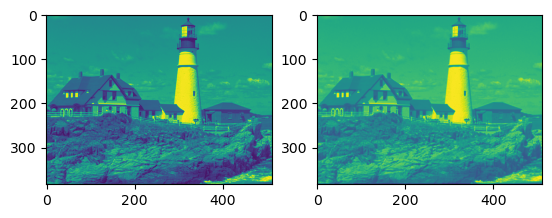

In [34]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(batch[0][0])
axes[1].imshow(pred[0])
plt.show()